# Brownian chiral particle. Tracking.

Developed by fvega@eaphysics.xyz; Lausanne jun-aug 2023

## <span style="color:red">*Import libraries* </span>

In [21]:
import sys
import gc
import numpy as np #numpy
import cmath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors 
import matplotlib.patches as patches
import matplotlib.font_manager
from IPython.display import display, HTML # screen on display in HTML library 
import platform

import multiprocessing as mp
import time
from pytictoc import TicToc

import pandas as pd
from pandas_ods_reader import read_ods #read ods tables
import scipy.signal as signal
import scipy.stats as stats
import ipywidgets as widgets


import pims
import cv2 as cv
import skimage as scikit
import trackpy as tp

%matplotlib --list
%matplotlib widget

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams.update({'font.size':14})

#print('\npandas version no.:', pd.__version__)

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()

print('Python version: ', platform.python_version())

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']
Python version:  3.9.16


In [2]:
print("Garbage collection thresholds:", gc.get_threshold())

Garbage collection thresholds: (700, 10, 10)


In [2]:
mp.cpu_count()

20

In [48]:
del datos 
del video
del masked_frame

In [49]:
gc.collect()

792

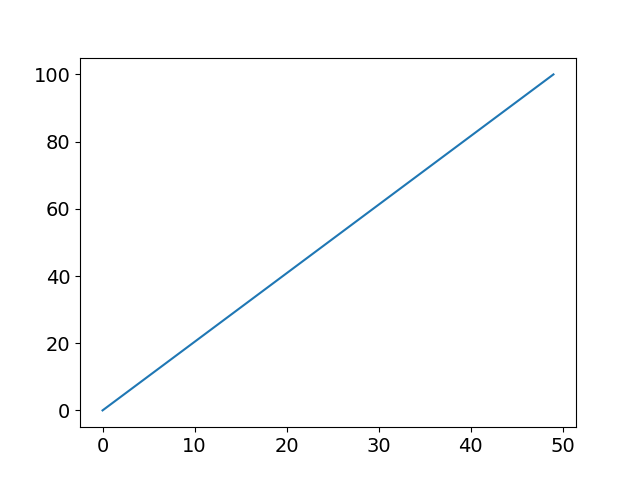

In [3]:
plt.figure(0)
plt.plot(np.linspace(0,100))

In [4]:
plt.close(0)

In [5]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

#from itables import show
#show(mpg[['mpg', 'name']])

ModuleNotFoundError: No module named 'itables'

In [3]:
def progreso(val,vmax):

    a= widgets.IntProgress(
        value=val,
        min=0,
        max=vmax,
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    return a

In [4]:
def pdisplay(info):
    display(HTML(info.to_html()))

## HTML video (mime type) viewer

In [5]:
%%HTML
<video width="416" height="400" controls>
  <source src="suppementary_video.mp4" type="video/mp4">
</video>

https://soft-matter.github.io/pims/v0.6.1/search.html?q## PIMS version

## <span style="color:red"> *READ video with PIMS (recommended)* </span>


pixel type is:  uint16

movie length is :  38419

image resolution is:  (832, 800)  (X ,Y )


first frame image:



Frame([[154, 159, 160, ..., 174, 152, 132],
       [144, 151, 153, ..., 183, 155, 150],
       [147, 141, 144, ..., 228, 176, 158],
       ...,
       [190, 189, 192, ..., 172, 128, 126],
       [188, 177, 182, ..., 124, 106, 109],
       [187, 176, 176, ...,  98,  97,  90]], dtype=uint16)
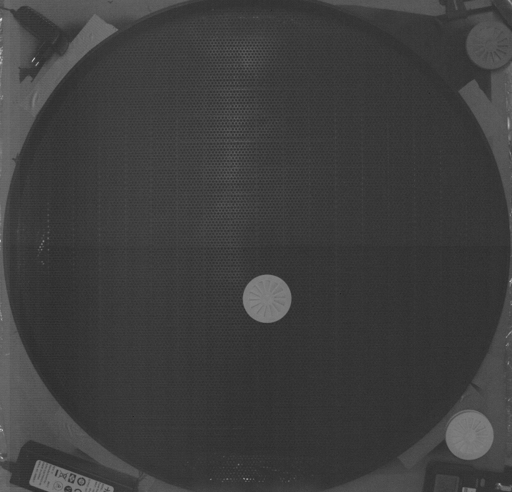

In [6]:
video = pims.Cine('/home/fvega/Datos/brownian/180322/blanca_245.cine')
print('\npixel type is: ', video.pixel_type)
print('\nmovie length is : ', video.len())
print('\nimage resolution is: ', video.frame_shape, ' (X ,Y )\n')
print('\nfirst frame image:\n')
video[video.image_count-1]

Frame([[160, 160, 157, ..., 174, 166, 143],
       [152, 151, 157, ..., 182, 166, 146],
       [151, 132, 142, ..., 224, 185, 160],
       ...,
       [185, 193, 185, ..., 176, 144, 133],
       [186, 182, 185, ..., 124, 115, 115],
       [179, 184, 173, ...,  95,  90,  97]], dtype=uint16)
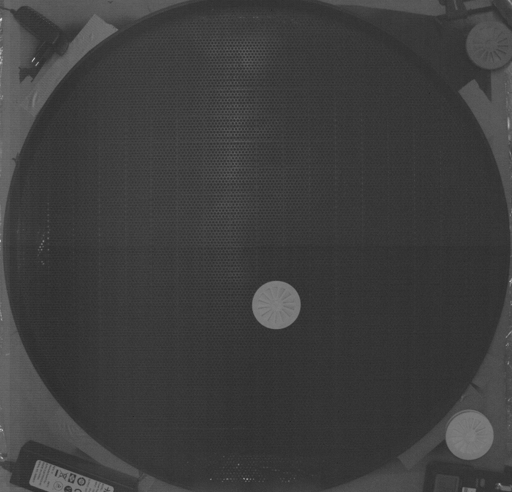

In [8]:
video[0]

## Examples of pims frames properties

In [11]:
# NUMBER OF FRAMES
video.image_count

38419

In [12]:
video.pixel_type

dtype('uint16')

In [13]:
video.frame_rate_avg

750.006704778444

In [14]:
video.frame_rate

750

In [7]:
video.frame_time_stamps[:5]

[(datetime.datetime(2022, 3, 18, 11, 13, 40), 0.06270710728131235),
 (datetime.datetime(2022, 3, 18, 11, 13, 40), 0.06404042872600257),
 (datetime.datetime(2022, 3, 18, 11, 13, 40), 0.0653737501706928),
 (datetime.datetime(2022, 3, 18, 11, 13, 40), 0.06670707161538303),
 (datetime.datetime(2022, 3, 18, 11, 13, 40), 0.06804039306007326)]

In [16]:
# MOVIE FRAME SHAPE
# X is 832 (no. of columns)
# Y is 800 (no. of rows)

video.frame_shape

(832, 800)

In [17]:
# NOTICE, HOWEVER:
np.shape(video[0])

(800, 832)

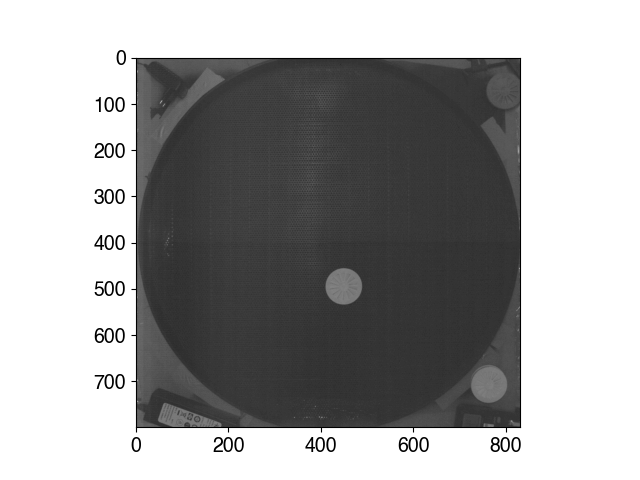

In [7]:
plt.figure(1)
plt.imshow(video[0], cmap='gray')

In [19]:
plt.close(1)

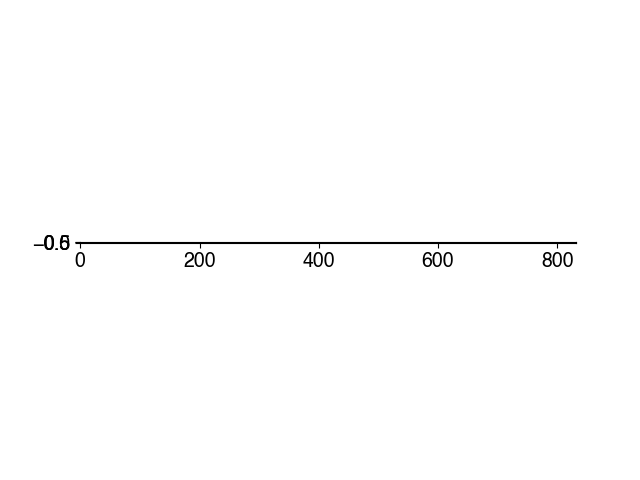

In [7]:
## MATRIX FORMAT: 
## first index is row (Y coord), second index is column (X coord)

# display first row complete (Y value, 1st index)
plt.figure()
plt.imshow(video[0][0:1,:], cmap=cm.binary_r)

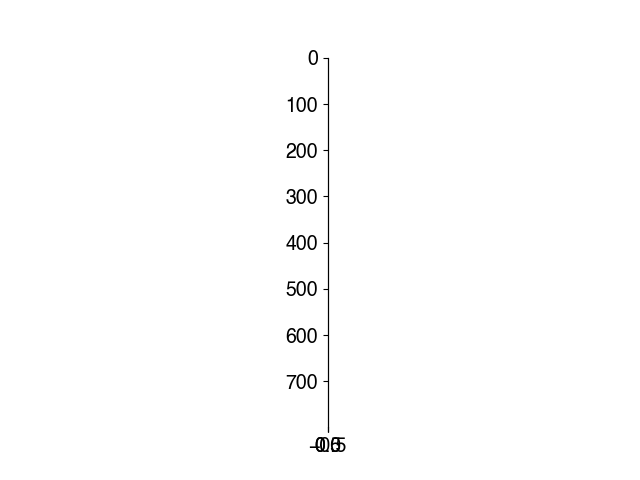

In [8]:
# display first column complete (X value, 2nd index)
plt.figure()
plt.imshow(video[0][:,0:1], cmap=cm.binary_r)
#plt.close()

255


Frame([[160, 160, 157, ..., 174, 166, 143],
       [152, 151, 157, ..., 182, 166, 146],
       [151, 132, 142, ..., 224, 185, 160],
       ...,
       [185, 193, 185, ..., 176, 144, 133],
       [186, 182, 185, ..., 124, 115, 115],
       [179, 184, 173, ...,  95,  90,  97]], dtype=uint8)
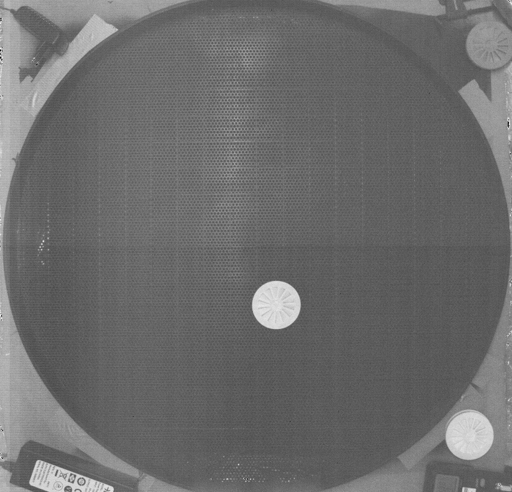

In [8]:
# standar conversion to 8-bit range ([0, 255])
print(np.max(video[0].astype('uint8')))
video[0].astype('uint8')


255


Frame([[160, 160, 157, ..., 174, 166, 143],
       [152, 151, 157, ..., 182, 166, 146],
       [151, 132, 142, ..., 224, 185, 160],
       ...,
       [185, 193, 185, ..., 176, 144, 133],
       [186, 182, 185, ..., 124, 115, 115],
       [179, 184, 173, ...,  95,  90,  97]], dtype=uint8)
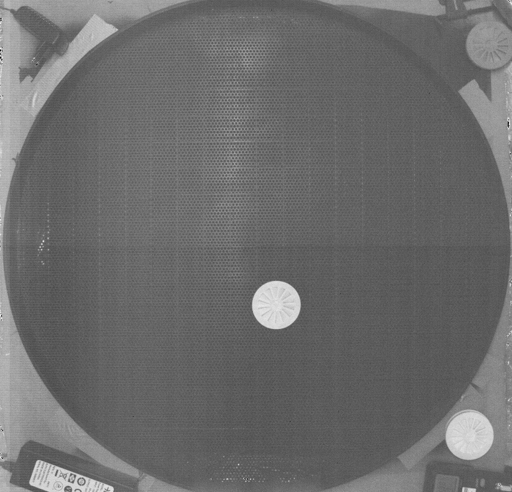

In [22]:
# numpy conversion to 8-bit range ([0, 255])
print(np.max(video[0].astype(np.uint8)))
video[0].astype(np.uint8)


In [21]:
# OpenCV conversion to 8-bit range ([0, 255])
print(np.max(cv.convertScaleAbs(video[0])))
cv.convertScaleAbs(video[0])


255


array([[160, 160, 157, ..., 174, 166, 143],
       [152, 151, 157, ..., 182, 166, 146],
       [151, 132, 142, ..., 224, 185, 160],
       ...,
       [185, 193, 185, ..., 176, 144, 133],
       [186, 182, 185, ..., 124, 115, 115],
       [179, 184, 173, ...,  95,  90,  97]], dtype=uint8)

## <span style="color:red"> *LOW-LEVEL Display Image functions* </span>

### <span style="color:red"> 1- _cvdisplay_: Display frame, OpenCV method (opens separate window) </span>
### <span style="color:red"> 2- _pltdisplay_: Display frame, plt.imshow METHOD </span>
### <span style="color:red"> 3- _get_frame_center_coords_: Display frame, plt.imshow METHOD </span>
### <span style="color:red"> 4- _black_frame_: Black service frame </span>
### <span style="color:red"> 5- _circle_mask_: Circular mask (arbitrary center) </span>
### <span style="color:red"> 6- _draw_circle_: Draw circle (arbitrary center)* </span>

* input: X image size, Y image size, x circle center pos, y circ center pos, circ radius, image to mask
* output: masked image (centered in image circle)

In [7]:
def cvdisplay(image, tag):
    canvas_name = "frame no. " + str(tag) + ";\tpres 'q' to exit"
    cv.imshow(canvas_name, cv.convertScaleAbs(image))
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def pltdisplay(S, frame, tag):
    canvas_name = 'frame no. ' + str(tag)
    plt.figure(tag,figsize=(S,S))
    plt.title(canvas_name)
    # alternatively convert to 8-bit use opencv function
    plt.imshow(frame, cmap=cm.binary_r)

def get_frame_center_coords(frame):
    LX = int(np.shape(frame)[1])
    LY = int(np.shape(frame)[0])
    ex0 = 10 # system center eccentricity (X); estimated by hand
    ey0 = 0 # idem, for Y # estimated by hand

    # center the circle
    x0 = int(LX/2) + ex0
    y0 = int(LY/2) + ey0
    # radius of the mask, approached over the image shortest side
    R = int(np.min(np.shape(frame)[0])/2)
    return x0, y0, R

def black_frame(LX, LY, datatype):
    bf = np.zeros((LY,LX), dtype=datatype)
    return bf

def circle_mask(x0, y0, R, image, base_frame):
    # base frame must be 8-bit
    cpbf = np.copy(base_frame)
    mf = cv.bitwise_and(image, image, mask = cv.circle(cpbf, (round(x0),round(y0)), round(R), 255, -1) )
    return mf
    # np.copy is necessary; otherwise cv.circle modifies base_frame

# for originally gray scale images
def circle_line(x0,y0, R, rc, gc, bc, w, image):
    return cv.circle( np.copy(cv.cvtColor(image, cv.COLOR_GRAY2RGB)), (round(x0),round(y0)), round(R), (bc,gc,rc), w)

# for originally RGB images
def circle_line_rgb(x0,y0, R, rc, gc, bc, w, image):
    return cv.circle( np.copy(image), (round(x0),round(y0)), round(R), (bc,gc,rc), w)


In [7]:
cvdisplay(video[0], 0)

qt.qpa.xcb: XKeyboard extension not present on the X server
QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is not the object's thread (0x56413cae58c0).
Cannot move to target thread (0x56413aa02e40)

QObject::moveToThread: Current thread (0x56413aa02e40) is 

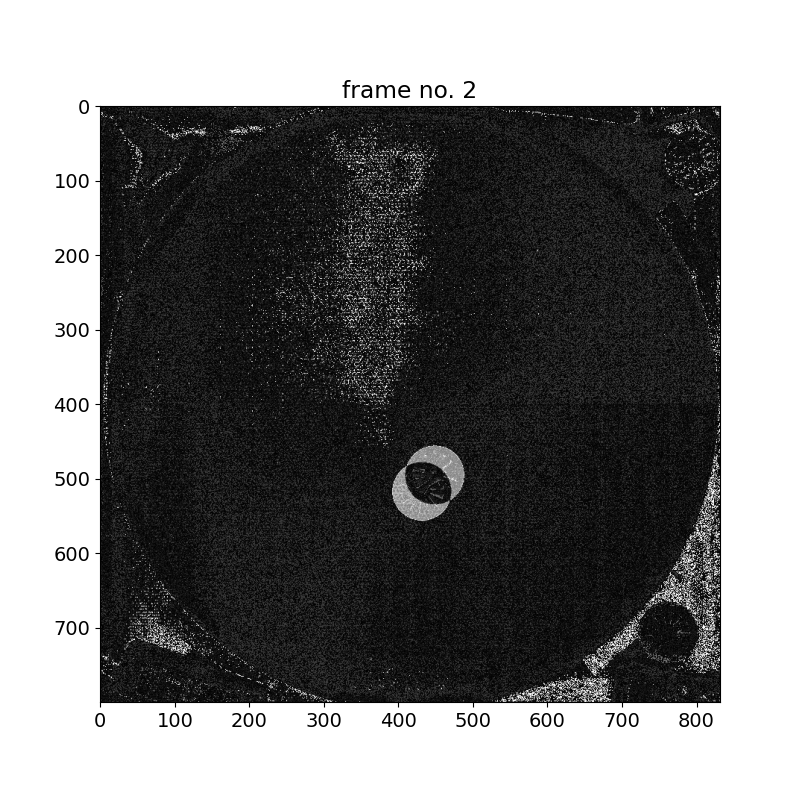

In [8]:
# bitwise_xor: highlights image differences
plt.close('all')
imm = cv.bitwise_xor(cv.convertScaleAbs(video[0]), cv.convertScaleAbs(video[2000]))
pltdisplay(8, imm, 2)

In [9]:
plt.close(2)

In [10]:
get_frame_center_coords(video[0])

(426, 400, 400)

In [8]:
black = black_frame(video.frame_shape[0], video.frame_shape[1], np.uint8)
#black16 = black_frame(video.frame_shape[0], video.frame_shape[1], np.uint16)
x0, y0, R = get_frame_center_coords(video[0])
masked_frame = circle_mask( x0, y0, R, video[0], black_frame(np.shape(video[0])[1], np.shape(video[0])[0], np.uint8) )
cvdisplay( masked_frame , 0)

qt.qpa.xcb: XKeyboard extension not present on the X server
QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is 

In [ ]:
# OPTIONAL: intensity (binary) threshold
ret, masked_th_frame = cv.threshold( masked_frame, 200, 255, cv.THRESH_TOZERO)
cvdisplay( masked_th_frame, 2)

## <span style="color:red"> Example of *BILATERAL smoothing* </span>

In [25]:
bilateral = cv.bilateralFilter(cv.convertScaleAbs(masked_frame), 10, 75, 75)

In [26]:
cvdisplay(bilateral, 4)

# <span style="color:cyan"> Main Processing functions </span>

## <span style="color:red"><u> Initial Hough Circle detection</u></span>

	cv.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)
    
( see: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d)


__im__: input image

__dp__: if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.

__param1__: edge threshold that will be used by the Canny edge detector (applied to a grayscale image). cvCanny(), internally invoked by cvHoughCircles(), accepts two thresholds. The higher (first) threshold is set to param1 (passed as argument into cvHoughCircles()) and the lower (second) threshold is set to half of this value.

__param2__: Is the value for accumulator threshold. This value is used in the accumulator plane that must be reached so that a line is retrieved.

OUTPUT:

__circles__: Array(s) with *[x0, y0, r]*; *(x0, y0)* center position, *r* particle radius

## <span style="color:red"> *DISK LOCATION function, using*  cv.HoughCircles </span>

dp: _Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height. For HOUGH_GRADIENT_ALT the recommended value is dp=1.5, unless some small very circles need to be detected._

param1:	_First method-specific parameter. In case of HOUGH_GRADIENT and HOUGH_GRADIENT_ALT, it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller). Note that HOUGH_GRADIENT_ALT uses Scharr algorithm to compute image derivatives, so the threshold value shough normally be higher, such as 300 or normally exposed and contrasty images._

param2:	_Second method-specific parameter. In case of HOUGH_GRADIENT, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadius] to avoid many false circles._

also:

param1 - _refers to the edge threshold that will be used by the Canny edge detector (applied to a grayscale image). cvCanny() accepts two thresholds and is internally invoked by cvHoughCircles(). Therefore the higher (first) threshold is set to param1 (passed as argument into cvHoughCircles()) and the lower (second) threshold is set to half of this value._

param2- _Is the value for accumulator threshold. This value is used in the accumulator plane that must be reached so that a line is retrieved._

NOTE: as param1 is increased, canny edge is more demanding and less disks are detected. param2 is always smaller than param1

## <span style="color:red">*Extract exact time stamps of all frames* </span>

* input: video frame (video_obj)
* output: 1D np array (t)

In [9]:
def locate_brownian_disk(image, m_dist, mr, Mr):
    #global lengths
    # loop over param1, increasing until less than 2 disks are detected for a (param1, param2=param1/10) set of values
    p1=100
    while len(\
              cv.HoughCircles(cv.convertScaleAbs(masked_frame), cv.HOUGH_GRADIENT, 2.-0.1*0, minDist=m_dist, param1=p1, param2=int(p1/10), minRadius=mr, maxRadius=Mr)[0]
             )> 1:
        p1 = p1 + 100
    # loop over dp parameter, decreasing its value (the smaller, the more precise, from 2.0 to 1.0; pick 1.7 if disk exist; if not, pick smaller). the smaller, the better
    test = [[] for i in range(11)]
    for i in range(11):
        test[i] = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2.-0.1*i, minDist=m_dist, param1=p1, param2=int(p1/10), minRadius=mr, maxRadius=Mr)[0]
        #assert (len(test[i]) == 1), f"THERE MUST BE (only) 1 DISK, but there are: {len(test[i])}"
    #lengths = np.array([ len(test[i]) for i in range(11)])
    for i in range(8):
        if len(test[7-i])==1:
            disk = test[7-i][0]
            dp = 1.7 - 0.1*i
            break
    #return disk, test, dp , p1, int(p1/100)
    return disk


def get_disk_aura(expand, in_level, out_level, image, bplot):
    
    ################################################################
    # CREATE AND DISPLAY AURA CONTOURS, for precise location of disk, by integration of disk optical borders

    # we define "AURA" as the disk optical border; i.e., the image region where its brightness decreases from disk image max to grid avg value
    # detect "aura" contours (SciKit) inside the preliminary mask around disk. detection by px brightness (level parameter)
    # inner aura contour, marking inner limit to disk optical boundary (aura) 
    contour_out = scikit.measure.find_contours(image, fully_connected='high', level=in_level ) # contour pixels at 100 value
    if np.shape(contour_out)[0] >1:
        print('outer contour detection failed\n')
    # outer contour, marks outer limit of disk optical boundary (aura); i.e., fading to background
    contour_in = scikit.measure.find_contours(image, fully_connected='high', level=out_level ) # contour pixels at 180 value
    if np.shape(contour_in)[0] >1:
        print('inner contour detection failed\n')

    # plot (matplotlib) detected aura contours
    if bplot == True:
        fig, ax = plt.subplots()
        plt.title('Disk Aura contours')
        ax.imshow(image, cmap=plt.cm.gray)
        for contour in contour_out:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        for contour in contour_in:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    return contour_in[0], contour_out[0]
    ################################################################

    
def get_masked_disk(contour_in, contour_out, image):
    
    ## OUTER CONTOUR mask, disk mask is now re-adjusted to aura outer limit
    #####################
    disk_mask = np.zeros(image.shape)
    
    # mask is rebuilt by means of SciKit draw.plygon procedure over, this time adjusting to outer contour
    xx, yy = scikit.draw.polygon(contour_out[:, 0], contour_out[:, 1], disk_mask.shape)
    disk_mask[xx, yy] = 255
    disk_mask = disk_mask.astype(np.uint8)
    #cvdisplay(disk_mask, 9)
    
    # create "masked disk" image, using outer contour: everything outside is wiped out, except for disk + aura
    masked_disk = cv.bitwise_and(image, image, mask = disk_mask)
    #cvdisplay(masked_disk,10)
    ################################################################
    
    ####################
    # INNER CONTOUR mask, for aura masking (preserves brightness structure of border, for better disk mass center calc
    ####################
    # (again) create template of disk_shaped mask
    disk_mask = np.zeros(image.shape)  
    # repeat procedure but this time draw inner region to contour_in
    xx, yy = scikit.draw.polygon(contour_in[:, 0], contour_in[:, 1], disk_mask.shape)
    disk_mask[xx, yy] = 255
    disk_mask = disk_mask.astype(np.uint8)
    
    # disk inside disk border  (aura masked out)
    masked_disk_2 = cv.bitwise_and(masked_disk, masked_disk, mask=disk_mask)
    #cvdisplay(masked_disk_2, 11)
    return masked_disk, masked_disk_2


def integrate_disk(masked_disk_2, masked_disk):

    # 1 STAGE: preparation of image for averaging
    # pixel average of disk inside disk border: m00/sum of non-black px
    px_avg_disk_2 = cv.moments(masked_disk_2)['m00']/np.sum(cv.threshold(masked_disk_2, 100, 1, cv.THRESH_BINARY)[1])
    px_avg_disk_2 = round(px_avg_disk_2)
    # replace inner full disk pixels with px avg
    masked_disk_2 = cv.threshold(masked_disk_2, 100, px_avg_disk_2, cv.THRESH_BINARY)[1]
    
    ## create inverse disk inner disk mask, with px avg, for selection only the aura
    disk_mask_2 = cv.threshold(masked_disk_2, 0, 255, cv.THRESH_BINARY_INV)[1].astype(np.uint8)
    # isolate and create image of aura (masked_aura)
    masked_aura = cv.bitwise_and(masked_disk, masked_disk, mask=disk_mask_2)
    # add disk aura + averaged inner mask
    disk_for_xy = cv.add(masked_disk_2, masked_aura)
    ##
    
    # 2nd STAGE: averaging of prepared disk image
    # obtain mass center from these 2 images sum. mass center is the improved disk center location
    momentos = cv.moments(disk_for_xy) # save moments of aura + inner avg disk mask
    dx0 = momentos['m10']/momentos['m00'] # mass center, X coordinate
    dy0 = momentos['m01']/momentos['m00'] # mass center, Y coordinate
    #print('( ', dx0,' ', dy0, ') \n')
    return round(dx0,4), round(dy0,4)


# This function obtains the exact time arrays
def to_time(video_obj):
    
    times = np.array(video_obj.frame_time_stamps).T
    t = np.zeros(video_obj.image_count) 
    s = times[0][0]
    ns = 0
    for i in range(video_obj.image_count):
        if times[0][i].second != s:
            ns = ns + 1
            s = times[0][i].second
        t[i] = times[1][i] + ns

    t = t - times[1][0]
    
    return t - 1.

# <span style="color:red"> Full processing function </span>: uses a combination of main functions (cell above) and gets X,Y disk coordinates for 1 frame
(masks disk based on previous disk location)

In [10]:
def simple_process(frame):

    ################################################################
    # PRODUCE ORIGINAL INPUT MASKED IMAGE, from video
    # get masked frame from movie frame
    
    # input parameters for masked_image
    x0, y0, R = get_frame_center_coords(frame)
    #def circle_mask(x0, y0, R, image, base_frame):
    black = black_frame(np.shape(frame)[1], np.shape(frame)[0], np.uint8)
    masked_frame = circle_mask( x0, y0, R, frame, black )# tentative particle diameter  (integer)
    
    ################################################################
    # HOUGH CIRCLE IDENTIFICATION, with automated choice set of hough parameters (only needs approx. particle diameter pre-input)
    ##################################   image in gray scale,            disk dist., min. diameter,  max. diameter
    
    ################################################################
    # DEFINE PARTICLE PARAMETERS for Hough Circle Detection
    sigma = 40
    # % of particle radius look & find range (integer)
    percent_ds = 8 
    # diameter interval (integer)
    Delta_sigma = int(sigma * 0.01 * percent_ds  )
    # expected distance between disks
    dsigma = 50
    ################################################################
    
    #def locate_brownian_disk(image, m_dist, mr, Mr):
    disk = locate_brownian_disk( cv.convertScaleAbs(masked_frame), dsigma, sigma-Delta_sigma, sigma+Delta_sigma)
    ################################################################  
    
    ################################################################
    # CREATE AND DISPLAY AURA CONTOURS, for precise location of disk, by integration of disk optical borders (previously passed over gauss. blurring)
    #################################
    
    # preliminary circular mask around located disk (OpenCV), expand% bigger than detected disk
    expand = 25 # expand 25%
    masked_disk = circle_mask(disk[0], disk[1], disk[2] * (1.+expand /100) , masked_frame, black)
    # GAUSSIAN+MEDIAN SMOOTHING over BILATERAL FILTERING
    blur_masked_disk = cv.GaussianBlur(cv.medianBlur(cv.bilateralFilter(cv.convertScaleAbs( masked_disk), 10, 75, 75), 5), (5,5), 0)
    # high-precision disk contours are obtained out of gaussian+median smoothed masked disk, after bilateral filtering
    # inner contour represents the disk image area that is 100% inside the disk
    # outer contour represents a circular ring where disk image fades. we call it 'aura'
    contour_in, contour_out = get_disk_aura(30, 105, 180, blur_masked_disk, False)
    
    # the line below is only for full-video display
    #masked_disk, masked_disk_2 = get_masked_disk(contour_in, contour_out, masked_disk)
    ################################################################
    
    ################################################################
    # HIGH PRECISION MASKED INNER DISK (masked_disk) AND AURA (masked_disk_2), USING INNER/OUTER CONTOURS
    #####################
    blur_masked_disk, blur_masked_disk_2 = get_masked_disk(contour_in, contour_out, blur_masked_disk)
    ################################################################
    if frame.frame_no%10==0:
        printp(str(frame.frame_no))
    ################################################################
    # INTEGRATION OF DISK BRIGHTNESS 
    #####################
    #dx0[i], dy0[i] = integrate_disk( masked_disk_2, masked_disk )
    #dx0[i], dy0[i] = integrate_disk( blur_masked_disk_2, blur_masked_disk )
    x, y = integrate_disk( blur_masked_disk_2, blur_masked_disk )
    y = (y - frame.shape[0]) * (-1) # y inversion (image, matrix-like y-coordinate to physical y-coordinate)
    ################################################################
    
    return x, y, frame.frame_no

In [11]:
###################  PARALLEL VERSION #################################################################################

#######################################################################################################################
########## initial disk detection, by detecting circle (OpenCV, see cell above and below for iteration) ###############
#######################################################################################################################

running_time = TicToc()

running_time.tic()

video = pims.Cine('/home/fvega/Datos/brownian/180322/blanca_245.cine')
print('\npixel type is: ', video.pixel_type)
print('\nmovie length is : ', video.len())
print('\nimage resolution is: ', video.frame_shape, ' (X ,Y )\n')
print('\nfirst frame image:\n')
video[video.image_count-1]

nframes = video.image_count # no. of frames to be processed # default: video.image_count

# create frame with one less row than time steps (last one does not have velocity)
datos = pd.DataFrame(index=np.arange(nframes), columns=['x', 'y', 'theta', 't'], dtype=np.float32)

datos.t = to_time(video) # arrange time column to physical time with t=0 at movie start
video = pims.Cine('/home/fvega/Datos/brownian/180322/blanca_245.cine')

#entry point for the program
if __name__ == '__main__':
    loop_chunk = 10000 # RAM is limited, so we divide movie parallel processing into chunks to iterate over
    dr = divmod(nframes,loop_chunk) # optional, for chunk size definition
    lr = [ loop_chunk*i for i in range(dr[0]+1)  ] # define each iteration limits, according to chunk size
    lr.append(loop_chunk*dr[0] + dr[1]) # last upper limit
    for j in range(dr[0]+1):
        # create the process pool (each iterated pool will die out the with environment)
        with mp.Pool(processes=10) as pool:
            # create list to iterate over (frame, frame no.)
            frame_list = [ (video[i]) for i in range(lr[j], lr[j+1]) ]
            # call the same function with different data in parallel
            for x, y, it in pool.imap(simple_process, frame_list):
                datos.at[it, 'x'], datos.at[it, 'y'] = x , y
                #printp( (x, y, it) )
            
#for disk in map(simple_process, [video[i] for i in range(nframes-10,nframes)]):
#    print(disk)
print('\n')
running_time.toc()


pixel type is:  uint16

movie length is :  38419

image resolution is:  (832, 800)  (X ,Y )


first frame image:

38410

Elapsed time is 2318.376672 seconds.


In [15]:
# average relative difference between actual average fr rate and nominal fps
100*(1-np.abs((np.mean(np.diff(datos.t)) - video.frame_rate)/video.frame_rate))

0.00017777619046865922

In [129]:
plt.figure(11, figsize=(6,6))
plt.plot(datos.x.values, (datos.y.values), '.', c='olive')


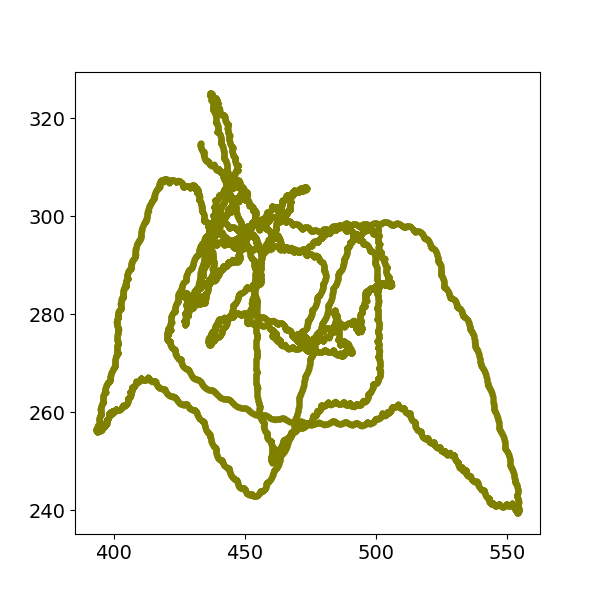

In [128]:
plt.figure(11, figsize=(6,6))
plt.plot(datos.x.values, -(datos.y.values-800), '.', c='olive')


In [127]:
np.shape(masked_disk)

(800, 832)

In [126]:
plt.close(11)

In [22]:
def circle_ring(x0, y0, R1, R2, frame, base_image):
    return circle_mask( int(x0), int(y0), R2, frame, base_image) - circle_mask( int(x0), int(y0), R1, frame, base_image) 

# CARTESIAN TO POLAR (2D)
def to_polar(x, y, x0, y0):
    r = np.sqrt((x-x0)**2+ (y-y0)**2)
    theta = np.heaviside(y-y0,1) * np.arccos((x-x0)/r) / np.pi + np.heaviside(y0-y,0) * ( np.pi + np.arccos((x0-x)/r) ) / np.pi
    return r, theta

def complex_to_polar(x, y, x0, y0):
    r, theta = cmath.polar( x-x0 + (y-y0)*1j )
    if theta < 0:
        theta = theta + 2 * np.pi
    return r, theta

def np_complex_to_polar(x, y, x0, y0):
    ln = len(x)
    r = np.zeros(ln)
    theta = np.zeros(ln)
    for i in range(ln):
        r[i], theta[i] = complex_to_polar(x[i], y[i], x0, y0)
    return r, theta
        
def complex_to_cart(r, theta, x0, y0):
    x = cmath.rect(r, theta).real + x0
    y = cmath.rect(r, theta).imag + y0
    return x, y
    
def np_complex_to_cart(r, theta, x0, y0):
    ln = len(r)
    x = np.zeros(ln)
    y = np.zeros(ln)
    for i in range(ln):
        x[i], y[i] = complex_to_cart(r[i], theta[i], x0, y0)
    return x, y

In [107]:
video = pims.Cine('/home/fvega/Datos/brownian/180322/blanca_245.cine')
iframe = 1
frame = video[iframe]
x0, y0, R = get_frame_center_coords(frame)
black = black_frame(video.frame_shape[0], video.frame_shape[1], np.uint8) 
masked_frame = circle_mask(x0, y0, R, frame, black)
################################################################
# DEFINE PARTICLE PARAMETERS for Hough Circle Detection
sigma = 40
# % of particle radius look & find range (integer)
percent_ds = 8 
# diameter interval (integer)
Delta_sigma = int(sigma * 0.01 * percent_ds  )
# expected distance between disks
dsigma = 50
################################################################
disk = locate_brownian_disk( cv.convertScaleAbs(masked_frame), dsigma, sigma-Delta_sigma, sigma+Delta_sigma)
    
# preliminary circular mask around located disk (OpenCV), expand% bigger than detected disk
expand = 25 # expand 25%
masked_disk = circle_mask(disk[0], disk[1], disk[2] * (1.+expand /100) , masked_frame, black)
blur_masked_disk = cv.GaussianBlur(cv.medianBlur(cv.bilateralFilter(cv.convertScaleAbs( masked_disk), 10, 75, 75), 5), (5,5), 0)
contour_in, contour_out = get_disk_aura(30, 105, 180, blur_masked_disk, False)
masked_disk, masked_disk_2 = get_masked_disk(contour_in, contour_out, masked_disk)  

In [18]:
cvdisplay(circle_ring(datos.x.values[0], datos.y.values[0], sigma*0.3, sigma*0.7, masked_disk, black),10)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to target thread (0x562f4e0c0c70)

QObject::moveToThread: Current thread (0x562f4e0c0c70) is not the object's thread (0x562f4df94f30).
Cannot move to tar

In [108]:
rescaled_masked_disk = scikit.exposure.rescale_intensity(masked_disk, in_range=(170,220),out_range=(90,255))
rescaled_masked_disk_ring = circle_ring(datos.x[iframe], datos.y[iframe], sigma*0.3, sigma*0.7, rescaled_masked_disk, black)
rescaled_masked_disk_ring = cv.convertScaleAbs(rescaled_masked_disk_ring)
cvdisplay( rescaled_masked_disk_ring ,10)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to target thread (0x55d2aaa88940)

QObject::moveToThread: Current thread (0x55d2aaa88940) is not the object's thread (0x55d2aac340c0).
Cannot move to tar

In [66]:
indices = np.where(rescaled_masked_disk_ring!=0) # we only work with pixels inside the ring
coordinates = list(zip(indices[0],indices[1])) # arrange all pixel coordinates for the ring
r5 , theta5 = to_polar( indices[1], (indices[0]-frame.shape[0]) * (-1), datos.x[iframe], datos.y[iframe]) # transform ring cartesian coordinates to polar

image_values5 = np.array([rescaled_masked_disk_ring[coordinates[i]] for i in range(len(coordinates)) ]) # build array with pixel values for each ring pixel
hist_theta5 = stats.binned_statistic(theta5, image_values, statistic='mean', bins=14*10*2) # get the angular histogram
peaks5, _ = signal.find_peaks(hist_theta5[0], distance=280/16)

In [109]:
indices = np.where(rescaled_masked_disk_ring!=0) # we only work with pixels inside the ring
coordinates = list(zip(indices[0],indices[1])) # arrange all pixel coordinates for the ring

r1, theta1 = np_complex_to_polar(indices[1],  (indices[0]-frame.shape[0]) * (-1), datos.x[iframe], datos.y[iframe])

image_values1 = np.array([rescaled_masked_disk_ring[coordinates[i]] for i in range(len(coordinates)) ]) # build array with pixel values for each ring pixel
hist_theta1 = stats.binned_statistic(theta1, image_values1, statistic='mean', bins=14*10*2) # get the angular histogram
peaks1, _ = signal.find_peaks(hist_theta1[0], distance=280/16)

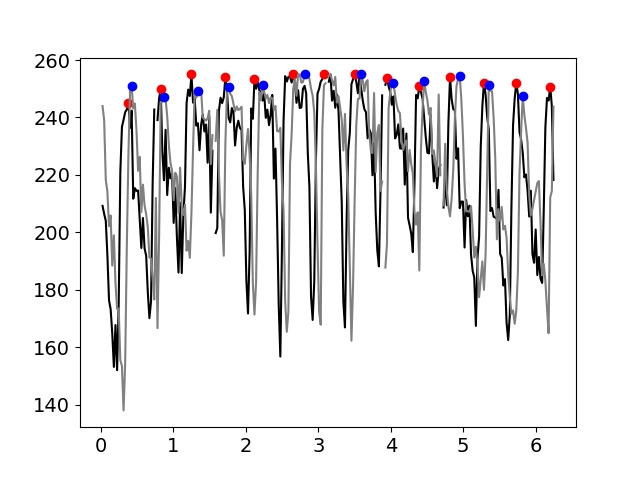

In [96]:
plt.figure(110)
#plt.plot(hist_theta[1][:-1]*(14/(2*np.pi)), hist_theta[0], c='k')
plt.plot(hist_theta[1][:-1], hist_theta[0], c='k')
plt.plot( hist_theta[1][peaks], hist_theta[0][peaks], 'o', c ='r')

plt.plot(hist_theta1[1][:-1], hist_theta1[0], c='grey')
plt.plot( hist_theta1[1][peaks1], hist_theta1[0][peaks1], 'o', c ='b')

#plt.plot(hist_theta1[1][:-1], hist_theta1[0], c='b')
#plt.plot(hist_theta2[1][:-1], hist_theta2[0],c='r')


In [95]:
plt.close(110)

In [37]:
hist_theta2[1][peaks2]

array([0.37884702, 0.82500612, 1.24885726, 1.71732432, 2.1188675 ,
       2.65425842, 3.07810956, 3.5019607 , 3.9481198 , 4.3942789 ,
       4.81813004, 5.28659709, 5.73275619, 6.20122324])

In [48]:
hist_theta[1][peaks]

array([0.37884702, 0.82500612, 1.24885726, 1.71732432, 2.1188675 ,
       2.65425842, 3.07810956, 3.5019607 , 3.9481198 , 4.3942789 ,
       4.81813004, 5.28659709, 5.73275619, 6.20122324])

In [226]:
rr, tt = np_complex_to_polar(indices[1], indices[0], datos.x[0], datos.y[0])

In [216]:
rr, tt = complex_to_polar(coordinates[0][1], coordinates[0][0], datos.x[0], datos.y[0])

In [241]:
rr[0], tt[0]

(28.417986309554017, 4.699984546228652)

In [238]:
x, y = np_complex_to_cart( rr, tt, datos.x[0], datos.y[0])

In [239]:
x[0], y[0]

(448.0, 467.0)

In [110]:
X1, Y1 = np_complex_to_cart( sigma*0.5*np.ones(len(peaks1)), hist_theta1[1][peaks1], datos.x[iframe], datos.y[iframe])

In [102]:
ref_image = np.copy(rescaled_masked_disk_ring)

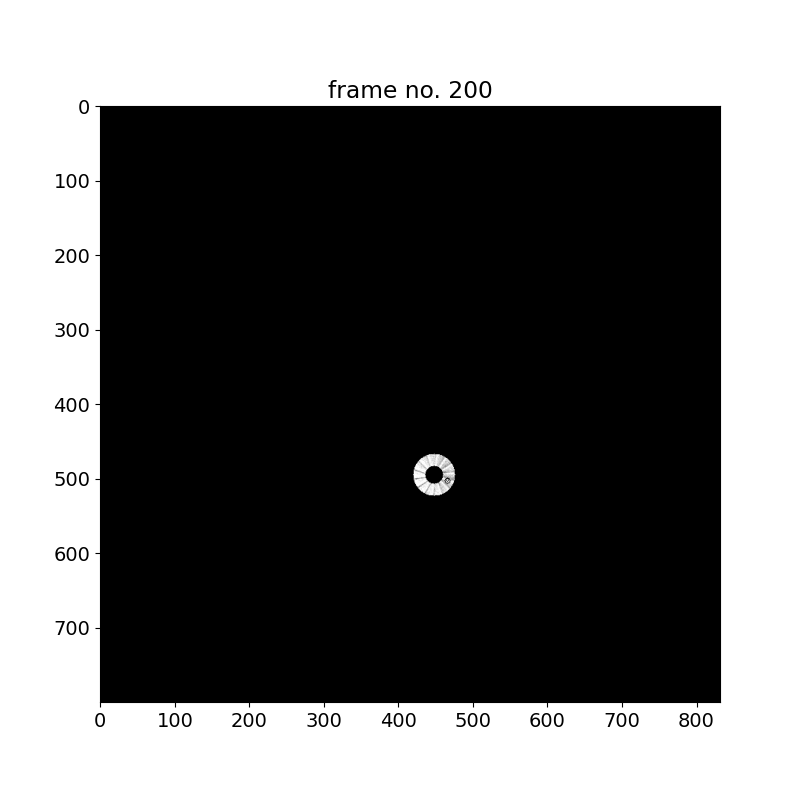

In [119]:
pltdisplay( 8, cv.circle(ref_image, (int(X1[0]), int(Y1[0])), int(0.1*sigma),(0,255,255), 1),200)

In [118]:
plt.close(200)

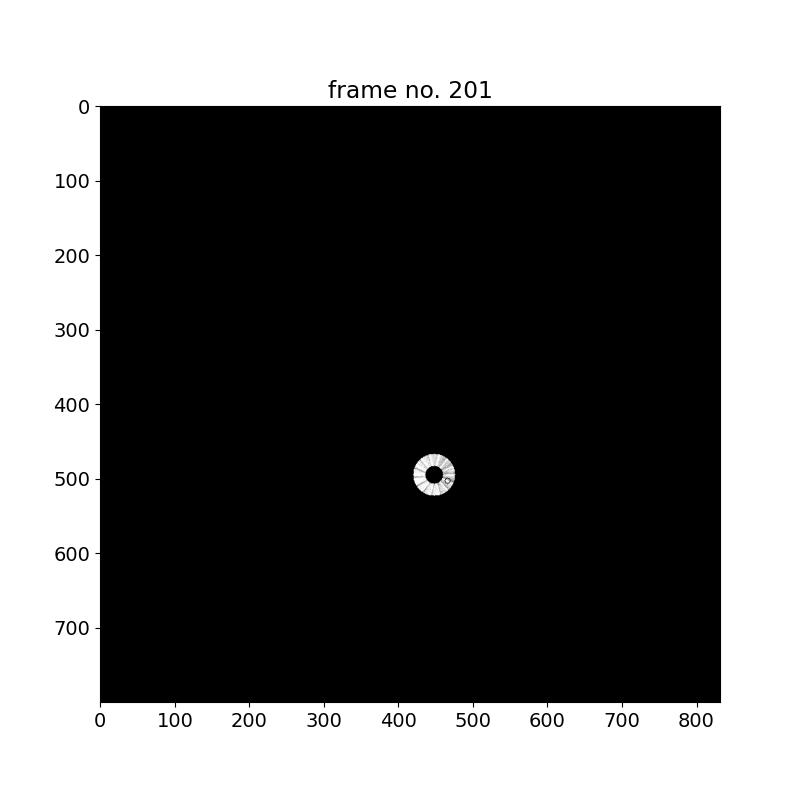

In [117]:
pltdisplay( 8, cv.circle(rescaled_masked_disk_ring, (int(X1[0]), int(Y1[0])), int(0.1*sigma),(0,255,255), 1),201)

In [251]:
0.1*sigma

4.0

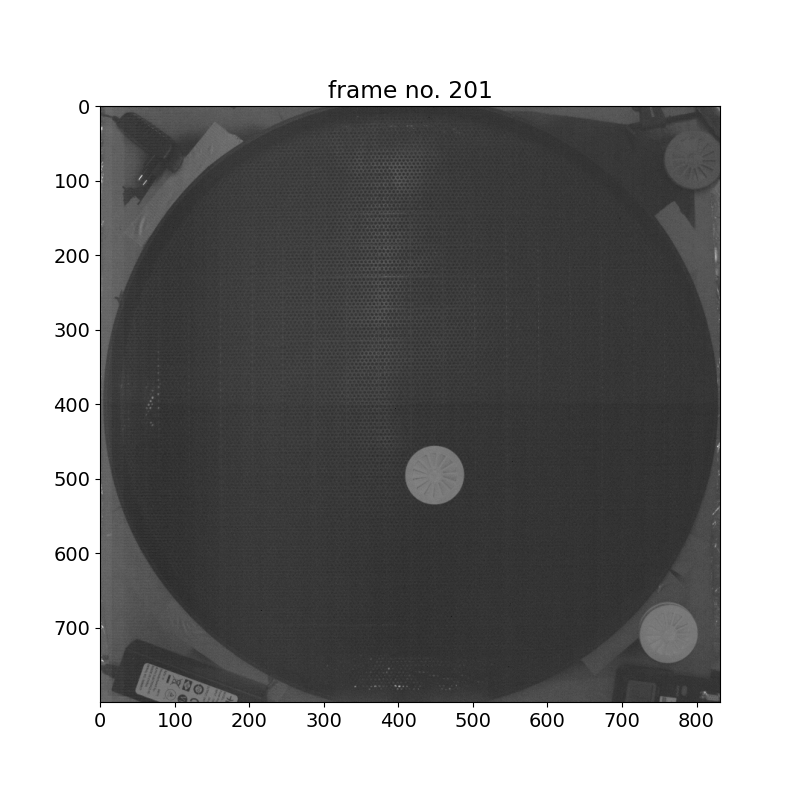

In [466]:
pltdisplay(8,video[0],201)

In [116]:
plt.close(201)

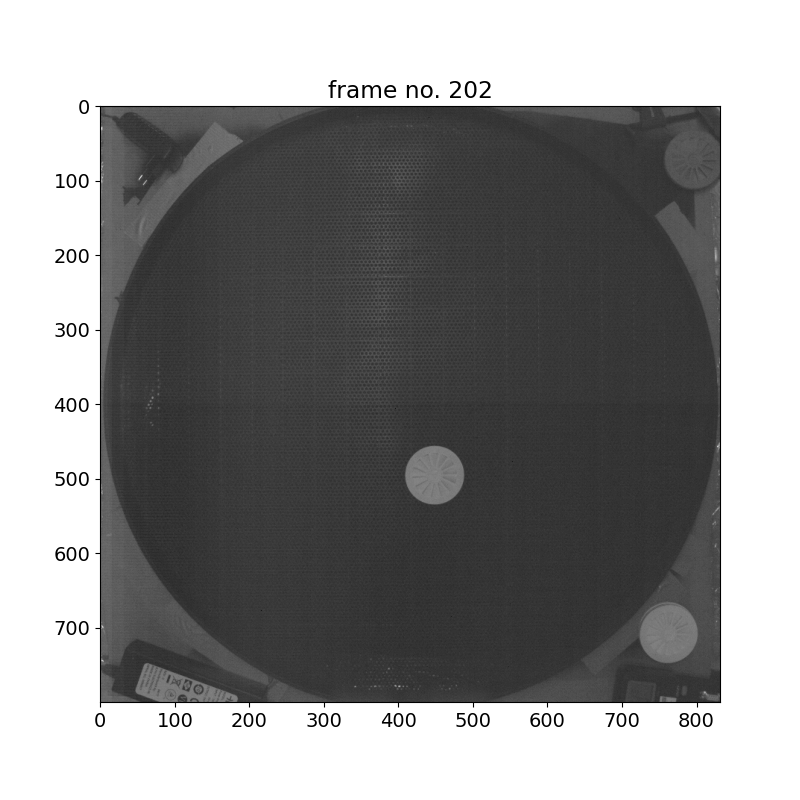

In [459]:
pltdisplay(8,video[1],202)

In [458]:
plt.close(202)

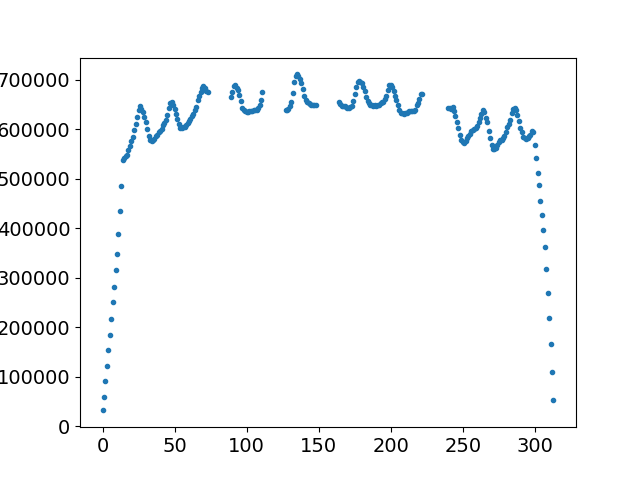

In [422]:
plt.figure(200)
correlacion = signal.correlate(hist_theta[0], hist_theta1[0][:15])
#correlacion = correlacion[(len(hist_theta[1])-len(hist_theta1[1])-1):len(correlacion)-((len(hist_theta[1])-len(hist_theta1[1])-1))]
plt.plot(correlacion,'.')

In [423]:
plt.close(200)

In [401]:
len(hist_theta[0])

300

In [424]:
lags = signal.correlation_lags(hist_theta[0].size, hist_theta1[0][:15].size)

In [425]:
lag = lags[np.argmax(correlacion)]

In [426]:
lag

60

In [399]:
np.argmax(correlacion)

74

In [ ]:
np.where(hist_theta[1]

In [373]:
len(correlacion)

701

In [379]:
plt.close(200)


In [338]:
len(correlacion)

701

In [322]:
l1 = [1,2,3,2,1,2,3]
l2 = [1,2,3]
signal.correlate(in1=l1, in2=l2)

array([ 3,  8, 14, 14, 10, 10, 14,  8,  3])

In [284]:
np.where(correlacion==np.max(correlacion))[0][0]

150

In [192]:
len(image_values)

2012

In [172]:
np.shape(coordinates)

(2012, 2)

In [185]:
image_values = np.array([rescaled_masked_disk_ring[coordinates[i]] for i in range(len(coordinates)) ])

dtype('float64')

In [206]:
def coords(m,n):
    return np.indices((m,n)).transpose(1,2,0)

In [239]:
np.mgrid[0:832, 0:800][0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [829, 829, 829, ..., 829, 829, 829],
       [830, 830, 830, ..., 830, 830, 830],
       [831, 831, 831, ..., 831, 831, 831]])

In [240]:
np.mgrid[0:832, 0:800][1]

array([[  0,   1,   2, ..., 797, 798, 799],
       [  0,   1,   2, ..., 797, 798, 799],
       [  0,   1,   2, ..., 797, 798, 799],
       ...,
       [  0,   1,   2, ..., 797, 798, 799],
       [  0,   1,   2, ..., 797, 798, 799],
       [  0,   1,   2, ..., 797, 798, 799]])

In [52]:
percentiles = tuple(np.percentile(masked_disk, (99., 99.95)))

In [58]:
cvdisplay( scikit.exposure.rescale_intensity(cv.convertScaleAbs(masked_disk), in_range=percentiles), 100)

In [75]:
r0, theta0 = to_polar( indices[1],indices[0], datos.x[0], datos.y[0])

In [76]:
r0, theta0

(array([28.41798631, 28.38459698, 28.14214537, ..., 27.1774529 ,
        27.40271786, 27.58645222]),
 array([4.69998455, 4.45036981, 4.48469763, ..., 1.36147005, 1.32576633,
        1.58357469]))

In [ ]:
# y indexes
np.where(rescaled_masked_disk_ring > 0 )[0]

In [70]:
# x indexes
np.where(rescaled_masked_disk_ring > 0 )[1]

array([433, 426, 427, ..., 439, 440, 433])

In [67]:
rescaled_masked_disk_ring[457,433]

198.9

In [73]:
np.shape(rescaled_masked_disk_ring)

(800, 832)

In [48]:
indexes = np.indices(np.shape(rescaled_masked_disk))

In [46]:
# draw results, adding system boundary and improved disk center location over masked_disk frame
pointed_disk = circle_line(dx0[nframes-1],dy0[nframes-1],1, 255,0,0, 1, masked_disk)
cvdisplay( cv.circle( pointed_disk, (x0,y0), R, (0,0,255), 2), 0 )

In [ ]:
cvdisplay( cv.add( cv.convertScaleAbs( scikit.filters.sobel(blur_masked_disk)), cv.convertScaleAbs(blur_masked_disk)), 5)

In [37]:
cvdisplay( cv.convertScaleAbs(blur_masked_disk), 6)

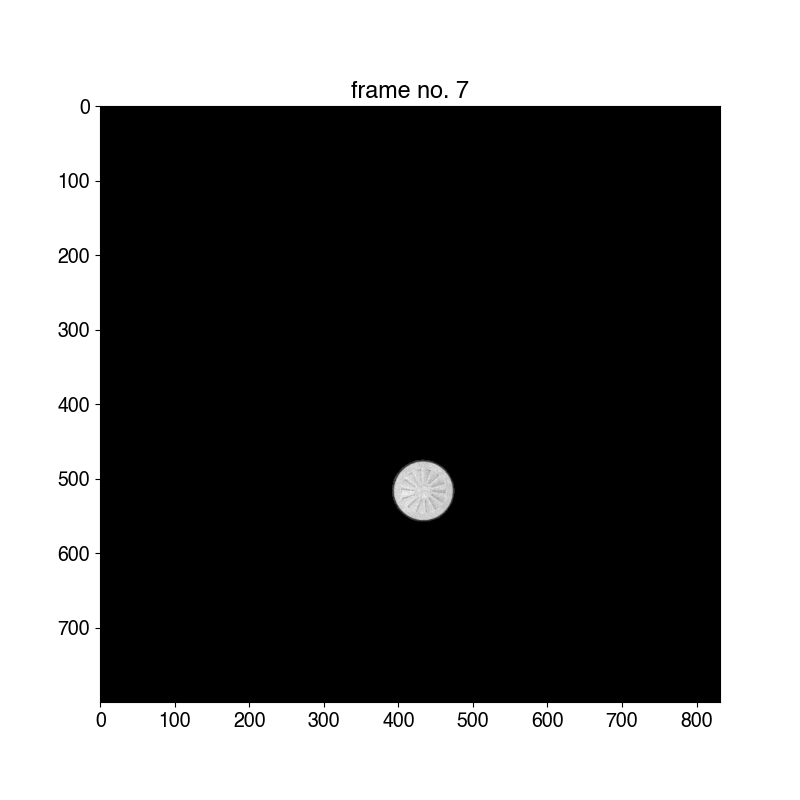

In [54]:
pltdisplay(8, scikit.exposure.adjust_gamma( masked_disk,1.5), 7)

In [55]:
plt.close('all')

In [37]:
len(np.where (cv.convertScaleAbs(blur_masked_disk)>-1 )[0])

665600

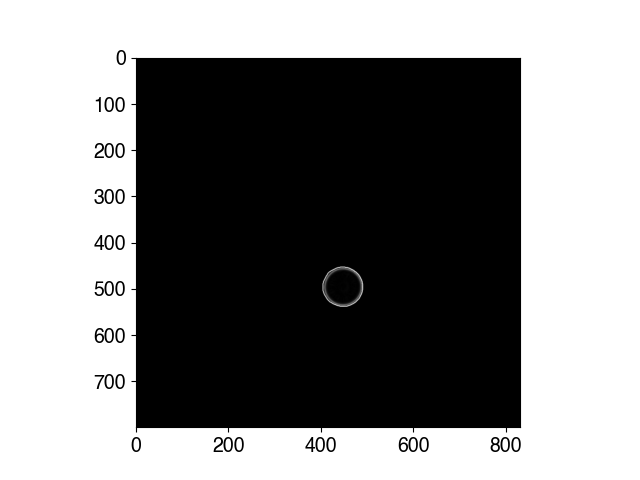

In [81]:
plt.figure(100)
plt.imshow( scikit.filters.sobel(blur_masked_disk), cmap=plt.cm.gray )

In [84]:
cvdisplay( cv.add( cv.convertScaleAbs( scikit.filters.sobel(blur_masked_disk)), blur_masked_disk), 35)

In [77]:
blur_masked_disk

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [76]:
plt.close('all')

In [58]:
cvdisplay(blur_masked_disk, 20)

In [237]:
# new_coordinates 
mini_disk = disk - np.array([ disk[0] -  sigma * 1.15,  disk[1] -  sigma * 1.15, 0])

In [189]:
mini_disk

array([44.   , 44.   , 37.455])

In [191]:
np.shape(mini_masked_frame)

(88, 88)

In [238]:
mini_masked_frame = \
masked_frame[ round(disk[1] -  sigma * 1.15): round(disk[1] + sigma * 1.15), round(disk[0] - sigma * 1.15): round(disk[0] + sigma * 1.15) ]

In [182]:
cvdisplay(mini_masked_frame, 22)

In [244]:
cvdisplay(cv.GaussianBlur(cv.medianBlur(cv.bilateralFilter(cv.convertScaleAbs( masked_frame), 10, 75, 75), 5), (5,5),0), 30)

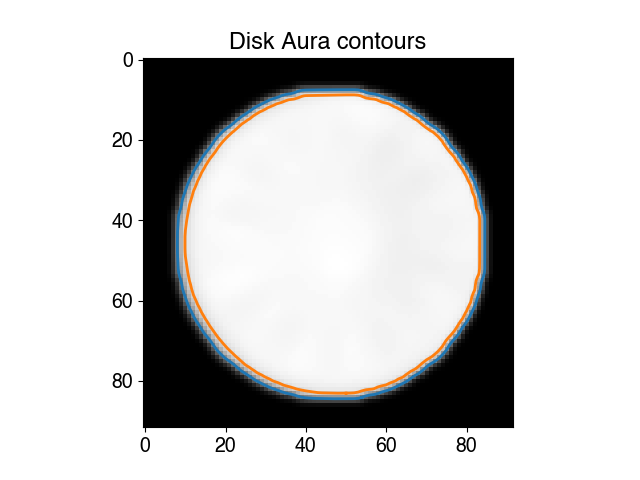

In [242]:
contour_in, contour_out, masked_disk = get_disk_aura(5,cv.bilateralFilter(cv.convertScaleAbs( mini_masked_frame), 10, 75, 75), mini_disk, True) 

In [245]:
cvdisplay( cv.bilateralFilter( cv.convertScaleAbs(mini_masked_frame), 10, 75, 75), 27)

In [250]:
plt.close('all')

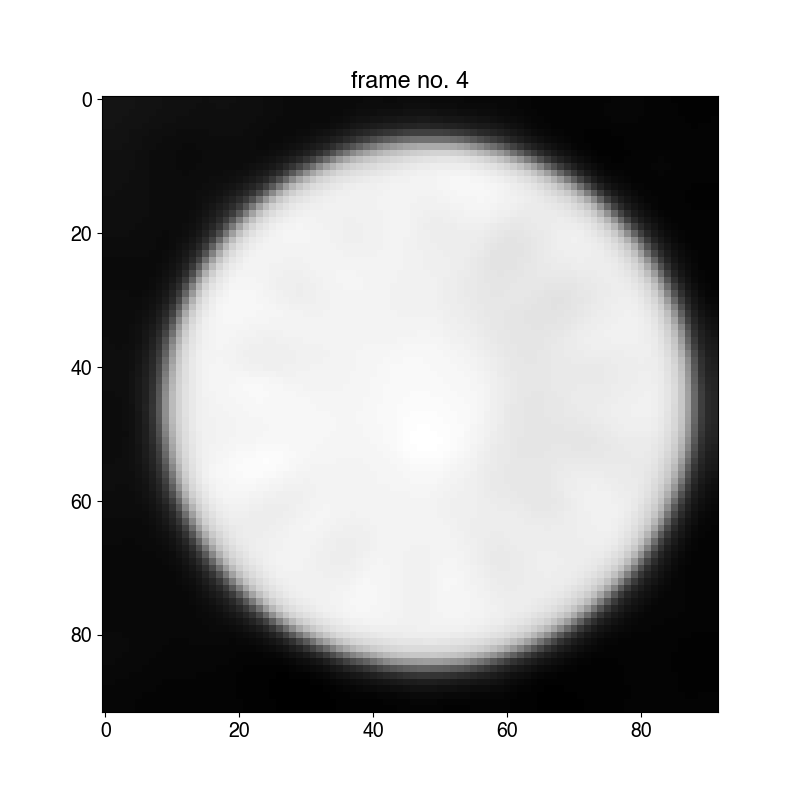

In [251]:
pltdisplay(8,cv.GaussianBlur(cv.medianBlur(cv.bilateralFilter(cv.convertScaleAbs( mini_masked_frame), 10, 75, 75), 5), (5,5),0), 4)

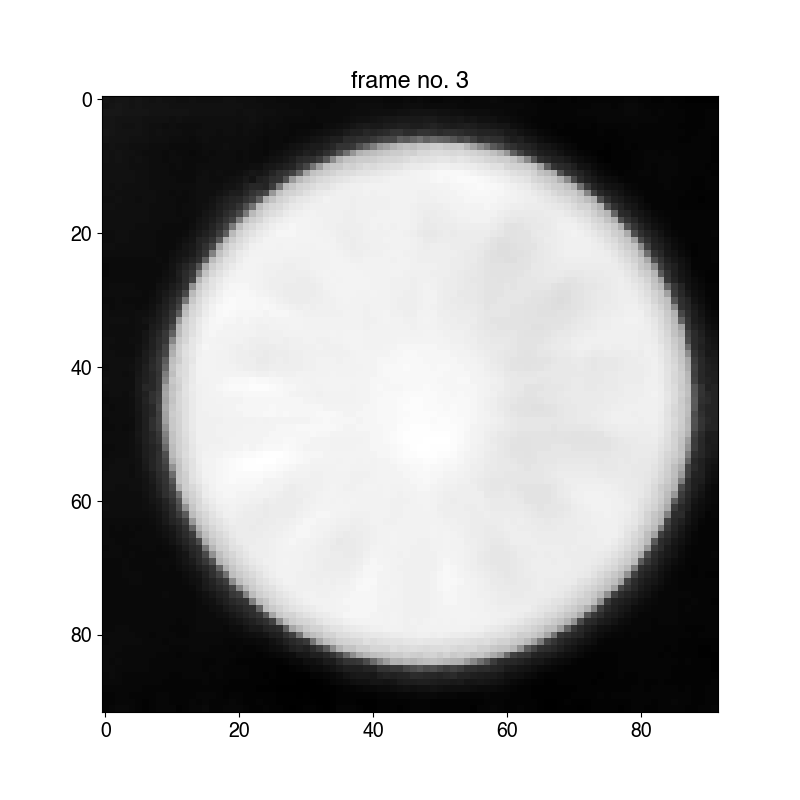

In [247]:
pltdisplay(8, cv.bilateralFilter(cv.convertScaleAbs(mini_masked_frame), 10, 75, 75), 3)

In [217]:
black = black_frame(masked_frame.shape[1], masked_frame.shape[0], np.uint8)

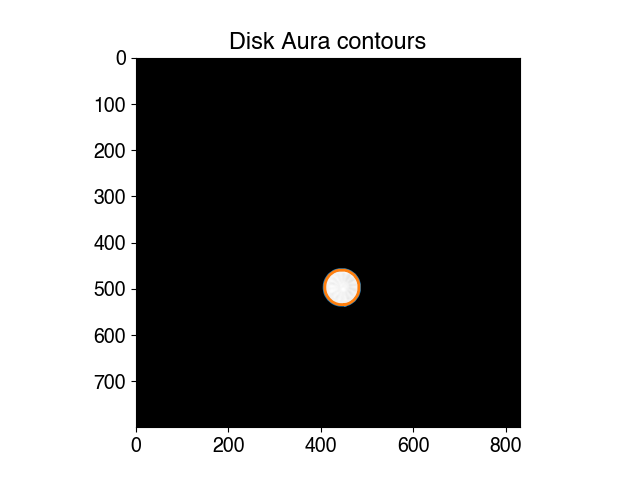

In [220]:
black = black_frame(masked_frame.shape[1], masked_frame.shape[0], np.uint8)
contour_in, contour_out, masked_disk = get_disk_aura(5, masked_frame, disk, True)

In [203]:
np.shape(masked_frame)

(800, 832)

In [176]:
circle_mask(mini_disk[0], mini_disk[1], mini_disk[2], mini_masked_frame, 

519

In [169]:
np.where(np.diff(dx0[:999])>1)[0]


array([33])

In [162]:
dx0[34]-dx0[35]

-1.5705000000000382

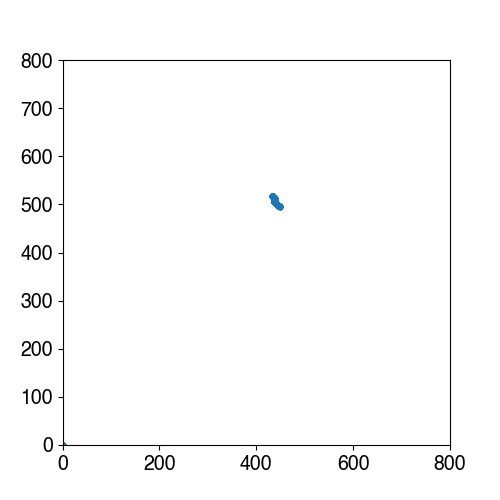

In [31]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)
plt.plot(dx0, dy0,'.')

In [33]:
plt.close('all')

In [55]:
np.set_printoptions(precision=3)  # For compact display.

In [32]:
xx = signal.savgol_filter(dx0[:999:3],4,3)
yy = signal.savgol_filter(dy0[:999:3],4,3)

In [149]:
X = signal.savgol_filter(signal.decimate(dx0[:999],3),4,3 )
Y = signal.savgol_filter(signal.decimate(dy0[:999],3) ,4,3)

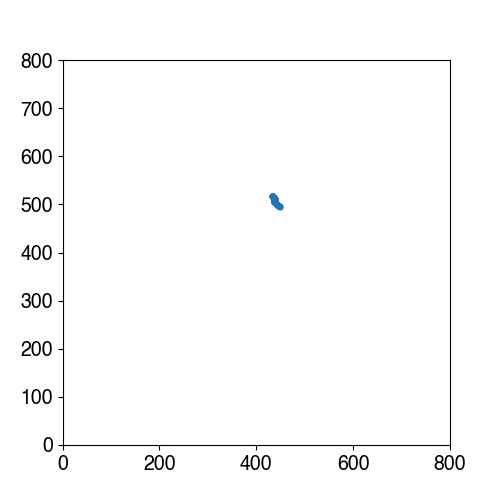

In [34]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)

plt.plot(xx, yy,'.')

In [151]:
video.frame_rate

750

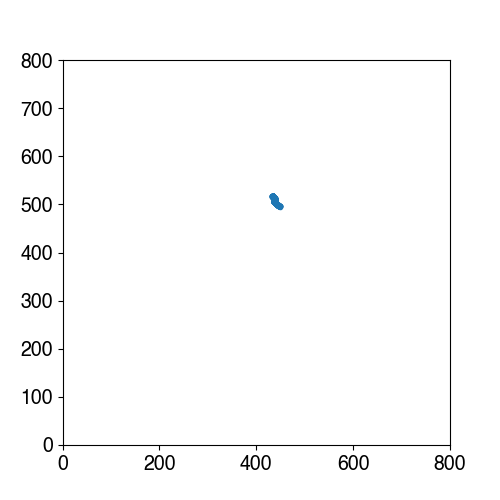

In [146]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)

plt.plot(xx, yy,'.')


#plt.plot(signal.decimate(dx0,3)[-10:], signal.decimate(dy0,3)[-10:],'.')

In [129]:
len(dx0)

38419

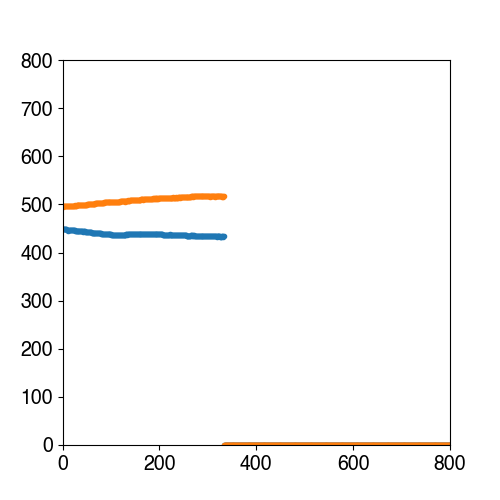

In [142]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)

plt.plot(dx0[::3],'.')
plt.plot(dy0[::3],'.')
#plt.plot(signal.decimate(dx0,3)[-10:], signal.decimate(dy0,3)[-10:],'.')

In [138]:
yy[-2000:]

array([0., 0., 0., ..., 0., 0., 0.])

In [125]:
len(X)

12807

In [110]:
dy0[999]

516.6286

In [82]:
plt.close('all')

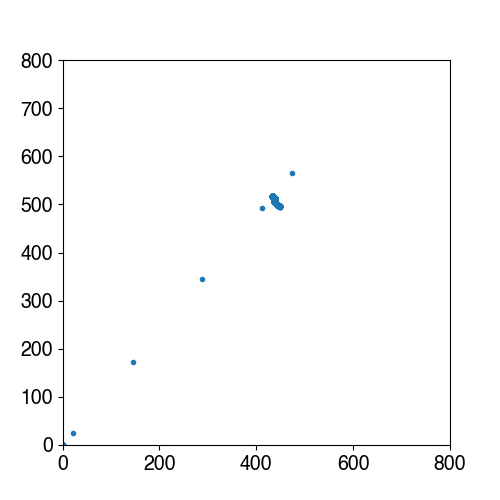

In [83]:
plt.figure(figsize=(5,5))
plt.xlim(0,800)
plt.ylim(0,800)
plt.plot(X, Y,'.')

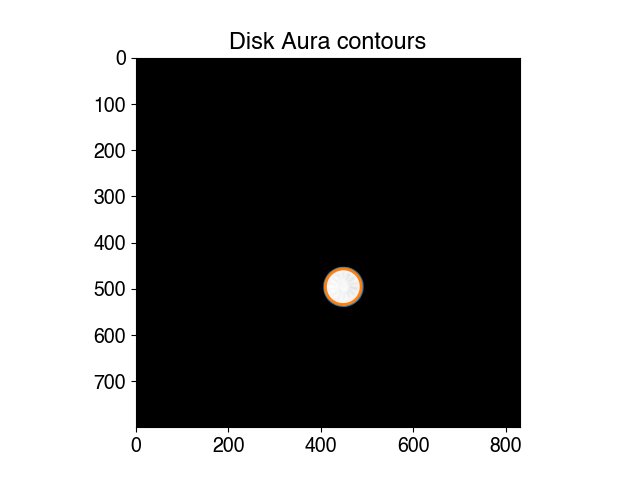

In [37]:
contour_in, contour_out, masked_disk = get_disk_aura(5, masked_frame, disk, True)

In [61]:
masked_disk, masked_disk_2 = get_masked_disk(contour_in, contour_out, masked_disk)

In [54]:
cvdisplay(masked_disk, 12)

In [44]:
integrate_disk(masked_disk_2, masked_disk)

(448.644597838575, 495.5765839396968)

In [19]:
system_transparency = 0.2
composed_frame = cv.addWeighted(masked_frame, system_transparency, masked_disk, 0.8-system_transparency, 0)
#cvdisplay(composed_frame,1)
circled_composed_frame = circle_line( x0, y0, R, 255,0,0,2, cv.convertScaleAbs(composed_frame))
cvdisplay(circled_composed_frame, 2)

In [108]:
circled_composed_frame.dtype

dtype('uint8')

In [28]:
cvdisplay(composed_frame,1)

In [23]:
image = masked_disk
# Rescale image intensity so that we can see dim features.
image = scikit.exposure.rescale_intensity(image, in_range=(120,255), out_range=(0,255))
kernel = np.ones((2, 2), np.uint16)
img_erode = cv.convertScaleAbs(cv.erode(image.astype(np.uint16), kernel, iterations=1))
cvdisplay(img_erode, 0)

In [33]:
img_erode.dtype

dtype('uint8')

In [26]:
_,alpha = cv.threshold(img_erode,0,255,cv.THRESH_BINARY)
rgba = cv.merge([img_erode, img_erode, img_erode, alpha], 4)
crop_rgba = rgba[:,250:1050]
cvdisplay(crop_rgba, 5)

In [29]:
fig4s = cv.imread('/home/fvega/Datos/blades/movies/fig4s.png')
cvdisplay( fig4s, 5)

In [30]:
neg_fig4s = cv.cvtColor( cv.threshold( fig4s, 210, 255, cv.THRESH_BINARY_INV)[1], cv.COLOR_BGR2GRAY)
masked_fig4s= cv.bitwise_and( fig4s,fig4s, mask=neg_fig4s)
cvdisplay( masked_fig4s, 6)

In [59]:
disk[1]

495.94998

In [64]:
round(disk[1],4)

495.95

In [66]:
round(disk[2],4)

39.99

In [28]:
cv.imwrite('/home/fvega/Datos/blades/movies/masked_fig4s.png' ,masked_fig4s)

NameError: name 'masked_fig4s' is not defined

In [103]:
# COMPLEX PHASE CROP

scale = 1/0.79
width = int(masked_fig4s.shape[1] * scale)
height = int(masked_fig4s.shape[0] * scale)
resc = (width, height)
resized_masked_fig4s = cv.resize(masked_fig4s, resc, interpolation = cv.INTER_AREA)
#cvdisplay(resized_masked_fig4s, 2)
crop_masked_fig4s = resized_masked_fig4s[173-40-10:173-40+800-10, 1100-40:1100-40+800]
cvdisplay( crop_masked_fig4s, 9)

In [ ]:
# C_ PHASE CROP
scale = 1/0.825
width = int(masked_fig4s.shape[1] * scale)
height = int(masked_fig4s.shape[0] * scale)
resc = (width, height)
resized_masked_fig4s = cv.resize(masked_fig4s, resc, interpolation = cv.INTER_AREA)
#cvdisplay(resized_masked_fig4s, 2)
crop_masked_fig4s = resized_masked_fig4s[150-40-10:150-40+800-10, 1985-40:1985-40+800]
cvdisplay( crop_masked_fig4s, 9)

In [35]:
crop_masked_frame = masked_frame[:,250:1050]
#cvdisplay(crop_masked_frame, 3)
rgb_crop_masked_frame = cv.cvtColor( cv.convertScaleAbs(crop_masked_frame), cv.COLOR_GRAY2BGR)
cvdisplay(rgb_crop_masked_frame, 8)

In [104]:
composed_im = cv.addWeighted(crop_masked_fig4s,0.9,rgb_crop_masked_frame , 0.3,0)
circled_composed_im =  circle_line_rgb(400,400,400,0,175,175,4, composed_im)
r, g , b = cv.split(circled_composed_im)
alpha2 = 255* np.ones((800,800)).astype('uint8')
alpha_composed_im = cv.merge([r,g,b,alpha2])
total_im = cv.addWeighted(crop_rgba , 0.7, alpha_composed_im, 1, 0)
cvdisplay(total_im, 7)

In [105]:
cv.imwrite('/home/fvega/Datos/blades/movies/test_v4_1.png', total_im)

True

In [138]:
pwd

'/home/fvega/Codigos/brownian'

In [37]:
lista_experimentos = read_ods('/home/fvega/Datos/blades/tabla_experimentos.ods', sheet=0)


In [50]:
lphi45 = lista_experimentos[lista_experimentos.phi==0.45]

In [52]:
lphi45

ID     N     P   phi    fps        Tt  \
61  5ac8543758342346a52402e578bfaf41  45.0  20.0  0.45  250.0  0.455877   
62  9bd37c11859b49f916d355e03d62a6fc  45.0  20.0  0.45  900.0  0.455877   
63  155e9e3bf635544e8ff7240c760bee7b  45.0  20.8  0.45  250.0  0.627246   
64  0aa7ece214139db8501bb5b4ac3fbdc1  45.0  21.0  0.45  250.0  0.706609   
65  48d0a742c060c9b28e30e8b2490c80bc  45.0  21.3  0.45  250.0  0.803102   
66  9cd14eb3963525cea5f0ea8e5ad33614  45.0  21.5  0.45  250.0  1.087504   
67  f509f3b902a7ada8064a9247404d7019  45.0  21.7  0.45  250.0  1.160905   
68  d55cb1546d02979fa61786c347dd440d  45.0  22.0  0.45  250.0  1.499319   
69  fa20f7895bd20257d9a2531abe98bf8e  45.0  22.0  0.45  250.0  1.692696   
70  656ac3f84a53672294b835362a2c563f  45.0  22.0  0.45  250.0  1.775451   
71  88b7a67af600a40edfc04b8a2487a511  45.0  22.0  0.45  900.0  1.775451   
72  db435326759f638689196d97f4f8fd45  45.0  22.4  0.45  250.0  1.728169   
73  edc6f35457554fd45382f6becdf41d97  45.0  23.0  0.45  250.0  2.646642   
74  712d5be2fce52eade6c5564a1f80368f  45.0  23.0  0.45  900.0  2.646642   
75  6c3eab3dea7b0313037973c260a421a1  45.0  24.0  0.45  250.0  3.188665   
76  0ac3fe44813e723638d804572aa69d8d  45.0  24.0  0.45  900.0  3.188665   
77  50b6e43e760b5946773274462ac6901b  45.0  24.0  0.45  250.0  3.253042   
78  34913bb5677f08882949585aabd7ee16  45.0  24.0  0.45  900.0  3.253042   

           w     w_std   u_air  sigma  ROI_center  ROI_radius  \
61 -0.387854  0.346244  2.3151   78.0  [656, 395]       408.0   
62 -0.387854  0.496392  2.3151   78.0  [656, 395]       408.0   
63 -0.245044  0.282056  2.3924   74.0  [662, 383]       381.0   
64 -0.150861  0.259200  2.4117   74.0  [662, 383]       381.0   
65 -0.107098  0.256426  2.4407   74.0  [662, 383]       381.0   
66  0.012065  0.254769  2.4600   74.0  [662, 383]       381.0   
67  0.055883  0.293315  2.4793   74.0  [662, 383]       381.0   
68  0.145326  0.311617  2.5083   74.0  [662, 383]       381.0   
69  0.162205  0.341537  2.5083   78.0  [656, 395]       408.0   
70  0.221584  0.347465  2.5083   78.0  [656, 395]       408.0   
71  0.221584  0.602791  2.5083   78.0  [656, 395]       408.0   
72  0.238652  0.311732  2.5469   74.0  [662, 383]       381.0   
73  0.516204  0.384537  2.6049   78.0  [656, 395]       408.0   
74  0.516204  0.761894  2.6049   78.0  [656, 395]       408.0   
75  0.729849  0.547261  2.7015   78.0  [656, 395]       408.0   
76  0.729849  0.753547  2.7015   78.0  [656, 395]       408.0   
77  0.760220  0.527186  2.7015   78.0  [656, 395]       408.0   
78  0.760220  0.822443  2.7015   78.0  [656, 395]       408.0   

                  serie  Tt_900fps  w_900fps                        unnamed.1  
61            nivelado1        NaN       NaN                             None  
62            nivelado1   8.824612 -0.413369                             None  
63  relleno_mapa_fases2        NaN       NaN                             None  
64  relleno_mapa_fases4        NaN       NaN                             None  
65  relleno_mapa_fases4        NaN       NaN                             None  
66   relleno_mapa_fases        NaN       NaN                             None  
67  relleno_mapa_fases4        NaN       NaN                             None  
68  relleno_mapa_fases2        NaN       NaN                             None  
69            nivelado0        NaN       NaN  VERSIÓN DE 900FPS NO DISPONIBLE  
70            nivelado1        NaN       NaN                             None  
71            nivelado1   5.929233  0.297060                             None  
72   relleno_mapa_fases        NaN       NaN                             None  
73            nivelado0        NaN       NaN                             None  
74            nivelado0   7.974890  0.525843                             None  
75            nivelado1        NaN       NaN                             None  
76            nivelado1   6.394996  0.734255                             None  
77          

In [49]:
lista_experimentos[(lista_experimentos.w > 0.25) & (lista_experimentos.w < 0.27)]

ID     N     P  phi    fps        Tt  \
34  44b967a39c4386471bfbda8d7a2af411  10.0  28.0  0.1  250.0  3.459757   
35  25bf2a638b2cb96ec6bf4b38b0314341  10.0  28.0  0.1  900.0  3.459757   

           w     w_std   u_air  sigma  ROI_center  ROI_radius      serie  \
34  0.263015  1.286315  3.0879   78.0  [656, 395]       408.0  nivelado0   
35  0.263015  2.348602  3.0879   78.0  [656, 395]       408.0  nivelado0   

    Tt_900fps  w_900fps unnamed.1  
34        NaN       NaN      None  
35   3.014863  0.024579      None

[357.69998  478.1       44.120003]


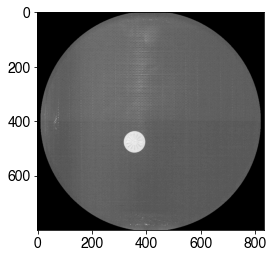

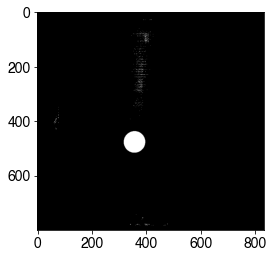

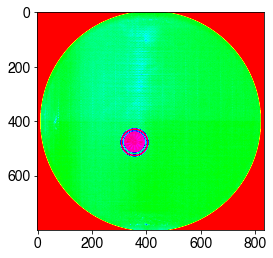

In [131]:
Rfact = 1.01 # factor of increase/decrease system radius
R =  0.5* np.min(np.shape(video[0])) # circular boundary radius, assuming image is adjusted to boundary

masked_image, image = circ_mask(cv.convertScaleAbs(video[0]), R, Rfact)

plt.figure()
plt.imshow(masked_image, cmap=cm.binary_r)

circles = None
dp = 1
tR = 45
dfact=2
cs = 2

# Iteratively search for disks, self-adjusting parameters to best fit
while cs>1:
    while circles is None and dp<tR:
        circles = locate_disk(masked_image, dp, dfact*tR, int(tR/2), tR)
        dp = dp + 0.1
    cs = np.shape(circles[0])[0]
    if cs>1: 
        dfact = dfact * 0.95
circles = circles[0,0]

print(circles)

inrange_image = cv.inRange(masked_image, 150, 255)

# Thresholding
plt.figure()
plt.imshow(inrange_image, cmap=cm.binary_r)

x0 = int(circles[0])
y0 = int(circles[1])
r = int(circles[2])

cir_image = np.copy(masked_image)
cv.circle(cir_image, (int(circles[0]),int(circles[1])), int(1.1*r), (255,255,0), 5);
plt.figure()
plt.imshow(cir_image,cmap=cm.hsv)



In [68]:
locate_disk(cv.inRange(imm, 150,255), 3.1, 100, 30, 45)

array([[[354.94998, 475.84998,  40.23   ]]], dtype=float32)

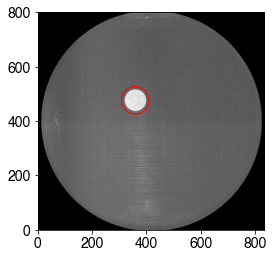

In [32]:

figure, axes = plt.subplots() 

cc = plt.Circle((circles[0], circles[1]), circles[2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


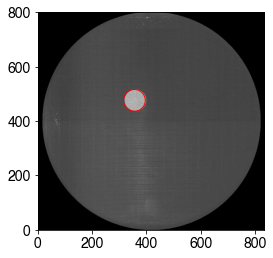

In [400]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5, 50
                          ,minRadius=30,maxRadius=50)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,832)
plt.ylim(0,800)
axes.add_artist(cc)
plt.imshow(masked_image, cmap=cm.binary_r)


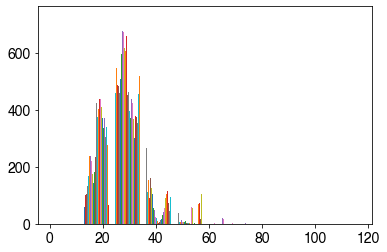

In [102]:
plt.hist(frame.T[0]);

In [142]:
ret, binary_ad = cv.threshold(image,40,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

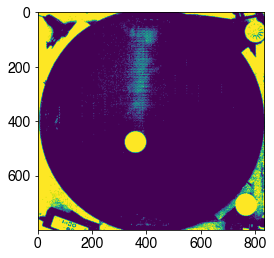

In [143]:
plt.figure()
plt.imshow(binary_ad)

TypeError: 'NoneType' object is not subscriptable

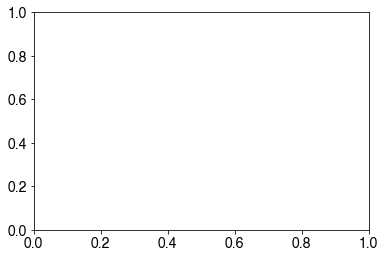

In [144]:
circles = cv.HoughCircles(binary_ad, cv.HOUGH_GRADIENT, 1,1
                          ,minRadius=10,maxRadius=90)

figure, axes = plt.subplots() 
cc = plt.Circle((circles[0,0,0], circles[0,0,1]), circles[0,0,2], edgecolor='r'
                ,facecolor='none' )
plt.xlim(0,800)
plt.ylim(0,832)
axes.set_aspect(1)
axes.add_artist(cc)
plt.imshow(image)

In [184]:
region = np.zeros((np.shape(image)[0], np.shape(image)[1]), dtype=np.uint8)
mask = cv.circle(region, (400,416), 410, 255, -1)

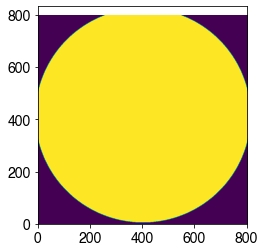

In [185]:
plt.figure()
plt.xlim(0,800)
plt.ylim(0,832)
plt.imshow(mask)



In [169]:
np.shape(image)

(800, 832)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [159]:
cv.HoughCircles(image, cv.HOUGH_GRADIENT, 2, 300
                          ,minRadius=1, maxRadius=500)

array([[[763. , 709. ,  38. ],
        [355. , 475. ,  41.2]]], dtype=float32)

In [68]:
np.shape(image)

(800, 832)

In [75]:
circles[0,0,1]

476.25

In [43]:
circles = cv.HoughCircles(image, cv.HOUGH_GRADIENT, 1.5,1
                          ,minRadius=1,maxRadius=90)

In [56]:
circles[0,0,0]

356.25

In [57]:
for i in icircles[0,:]:
    # draw the outer circle
    cv.circle(frame.T[0],(i[0],i[1]),i[2],(0,255,0),2)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:
cv2.waitKey(0) 

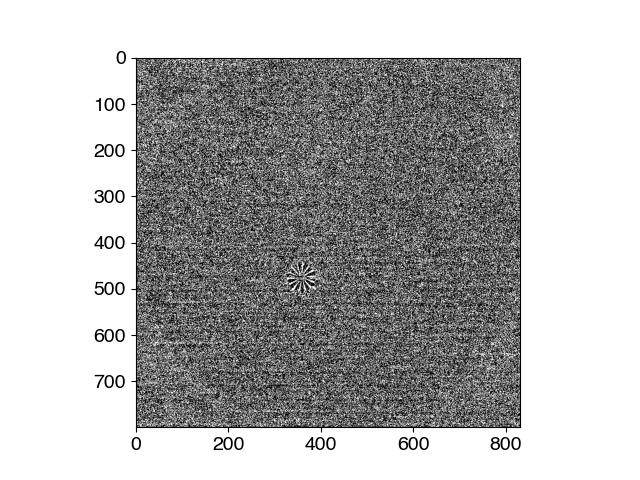

In [14]:
plt.figure(1)
plt.imshow(video[1]-video[0])

In [5]:
datos = pd.read_pickle('tracks/3988fa72e13c390c35b4a55c0495bc63.pkl.xz')
datos = datos[['x','y','frame']]

X = datos.x.values
Y = datos.y.values
it = datos.frame.values
xf = signal.savgol_filter(X, 9, 5)
yf = signal.savgol_filter(Y, 9, 5)
vxf = xf[1:] - xf[:-1]
vyf = yf[1:] - yf[:-1]
xf = xf[:-1]
yf = yf[:-1]

nframes = len(datos)-1

datos.head()


x           y  frame
0  363.396279  533.013782      1
1  363.571671  533.130123      2
2  363.886110  533.025815      3
3  363.869190  533.091061      4
4  363.420557  533.088331      5

In [6]:
def update(dt):
    plt.close('all')
    fig = plt.figure(figsize=(7.5,6))
    cmm = colors.ListedColormap.reversed(cm.viridis)
    ecolors = (cm.viridis_r((it[::dt]/ it[::dt].max()) ))
    dr = np.max([xf.max()-xf.min(), yf.max()-yf.min()]) *1.1
    plt.xlim(xf.min()*0.9,xf.min()+dr)
    plt.ylim(yf.min()*0.9,yf.min()+dr)
    plt.scatter(xf[::dt], yf[::dt], s=80, facecolors='none', edgecolors=ecolors, linewidths=0.75, alpha=0.75)
    normc = norm = colors.Normalize(vmin=0, vmax=100)
    cbar=plt.colorbar(cm.ScalarMappable(cmap=cm.viridis_r, norm = normc),
                      label= 'time (% of movie length)',orientation="vertical",shrink=0.99)
    #fig.canvas.draw() # with inline
    #fig.show() # with ipympl
    #return fig

In [7]:
plt.close('all')
fig = widgets.interact(update,dt=widgets.BoundedIntText(min=1, max=500, step=1, value=50));

interactive(children=(BoundedIntText(value=50, description='dt', max=500, min=1), Output()), _dom_classes=('wi…

In [9]:
datos.to_csv('tabla.csv')

In [44]:
histx, edgesx = np.histogram(vxf, bins=100, density=True)
histy, edgesy = np.histogram(vyf, bins=100, density=True)
hist, edges = np.histogram(np.sqrt(vxf**2+vyf**2), bins =200, range= (0,1.2),density=True)

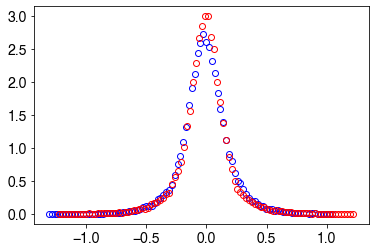

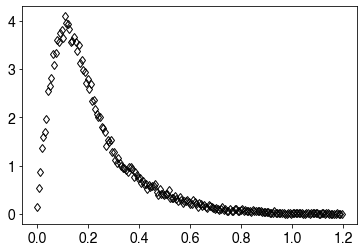

In [47]:
plt.close('all')
plt.figure(2)
plt.plot( edgesx[:-1], histx,'o',mfc='none', mec='b');
plt.plot(edgesy[:-1], histy, 'o', mfc='none',mec='r');
plt.figure(3)
plt.plot(edges[:-1], hist, 'd',c='k',mfc='none');